In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
import os 
if not os.path.exists('./gan_images'):
    os.makedirs('./gan_images')

In [7]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
#1차원으로 늘어선 100픽셀의 노이즈를 만든다. 
#128*7*7은 7*7이미지 128장을 만든다는 것을 읽기 쉽도록 표현한것으로 저 계산값을 그대로 넣어줘도 된다.
generator.add(BatchNormalization())
#가중치 값들을 평균이 0 표준편차가 1을 갖는 상태로 만들어주는게 batch normalization 일종의 정규화 작업으로 
#배치값들이 튀지 않게 해주는것이다. 
generator.add(Reshape((7,7,128)))
#3차원 이미지로 리쉐입한다. 
generator.add(UpSampling2D())
#UpSampling은 MaxPooling과는 반대의 개념으로 가로새로를 확장시키는것이다. 
generator.add(Conv2D(64, kernel_size=5, padding ='same'))
generator.add(BatchNormalization())
#batchnormalization을 이렇게 여러번 넣는것은 경험적으로 터득하게되는 결정이다. 이 쯤에 넣으면 최상이라는 것이다.
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding = 'same', activation='tanh'))
#여기서 1개를 출력하는것은 어떤 이미지 하나를 만들어내겠다는것이다.

#>>>> 이상이 generator를 만드는 방법이다. 

In [6]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)       

In [3]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = 5, strides=2, input_shape=(28,28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size = 5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [4]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False
#discriminator는 generator가 학습하는 동안에는 학습을 하면안되는데 진위판별 기준이 바뀌면 안되기 때문이다. 

In [5]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [8]:
#keras에서 제공하는 제너레이터와 디스크리미네이터를 합치는 방법
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer = 'adam')
gan.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential (Sequential)      (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [18]:
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()
    #test데이터가 필요없는데 discriminator가 알아서 테스트하기 때문이다.
    #마찬가지로 타겟값역시 discriminator의 것을 쓴다. 
    X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype('float')
    X_train = (X_train - 127.5)/ 127.5
    #전체 픽셀 데이터를 -1에서 1사이로 마춘것이다. 
    
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)
        #train_on_batch : 배치가 도는 순간 학습을 시키는 함수임 
        #타겟은 전부 트루다라는 방식으로 학습을 시킵니다. 
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        #현재 가중치와 파라미터를 기준으로 결과를 추측해주는게 predict 
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        #fake가 들어왔을 때의 손실값을 구한다. 
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        #discriminator의 평균 손실을 구해본다. 
        g_loss = gan.train_on_batch(noise, true)
        #트루일때 간 네트워크의 손실값을 구한다. 이 때는 generator만 학습을 하는 단계이다. 
        
        print('epoch: %d' % i, 'd_loss: %.4f' % d_loss, 'g_loss: %.4f' % g_loss)
        
        if i % saving_interval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)
            
            gen_imgs = 0.5 * gen_imgs + 0.5 
            #이미지를 0~1 사이로 rescale한다. 
            
            fig, axs = plt.subplots(5,5)
            count = 0 
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1 
            fig.savefig('gan_images/gan_mnist_%d.png' % i)

epoch: 0 d_loss: 0.5500 g_loss: 0.3019
epoch: 1 d_loss: 0.5299 g_loss: 0.1882
epoch: 2 d_loss: 0.5122 g_loss: 0.2106
epoch: 3 d_loss: 0.4793 g_loss: 0.2818
epoch: 4 d_loss: 0.4748 g_loss: 0.3989
epoch: 5 d_loss: 0.4782 g_loss: 0.5147
epoch: 6 d_loss: 0.4780 g_loss: 0.5874
epoch: 7 d_loss: 0.5182 g_loss: 0.5213
epoch: 8 d_loss: 0.5231 g_loss: 0.4772
epoch: 9 d_loss: 0.5209 g_loss: 0.4236
epoch: 10 d_loss: 0.5103 g_loss: 0.3834
epoch: 11 d_loss: 0.4949 g_loss: 0.3701
epoch: 12 d_loss: 0.4556 g_loss: 0.4227
epoch: 13 d_loss: 0.4595 g_loss: 0.5114
epoch: 14 d_loss: 0.4512 g_loss: 0.4728
epoch: 15 d_loss: 0.4182 g_loss: 0.4570
epoch: 16 d_loss: 0.4106 g_loss: 0.4922
epoch: 17 d_loss: 0.3891 g_loss: 0.4856
epoch: 18 d_loss: 0.4117 g_loss: 0.5214
epoch: 19 d_loss: 0.3935 g_loss: 0.6089
epoch: 20 d_loss: 0.3870 g_loss: 0.5531
epoch: 21 d_loss: 0.3912 g_loss: 0.4804
epoch: 22 d_loss: 0.3644 g_loss: 0.4318
epoch: 23 d_loss: 0.3850 g_loss: 0.5619
epoch: 24 d_loss: 0.3920 g_loss: 0.5939
epoch: 25 

C:\Users\fplc8\AppData\Local\Temp/ipykernel_3148/3181081921.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(5,5)


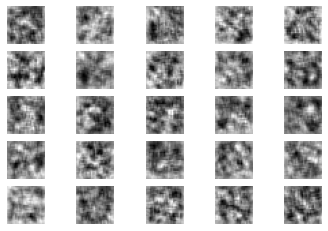

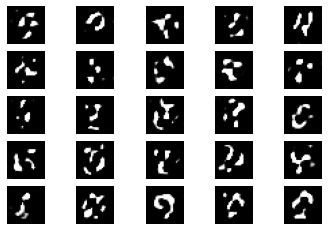

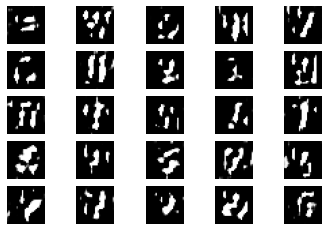

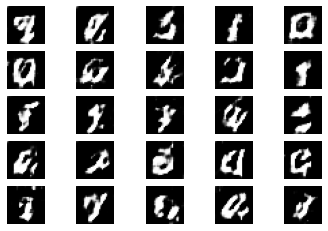

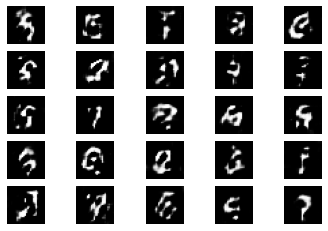

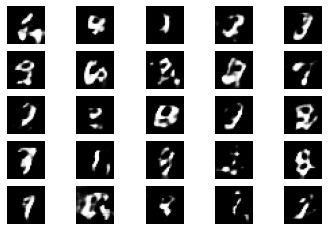

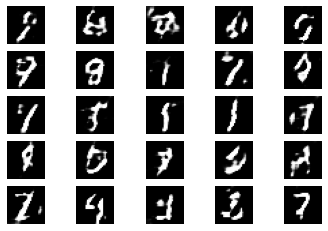

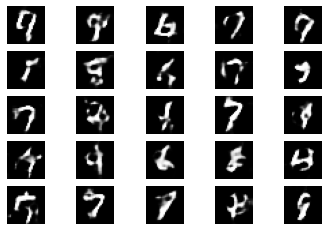

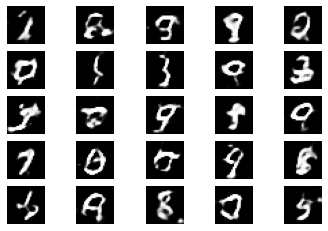

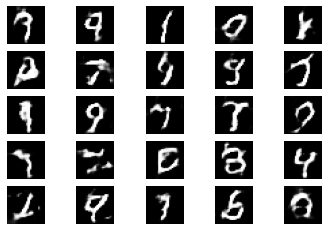

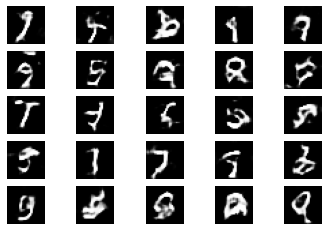

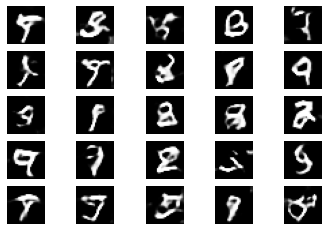

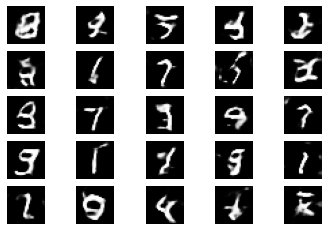

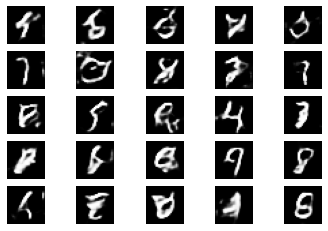

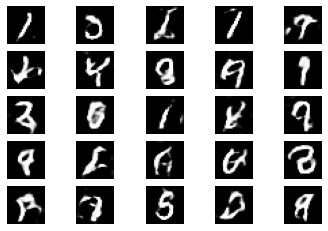

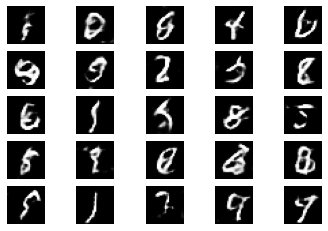

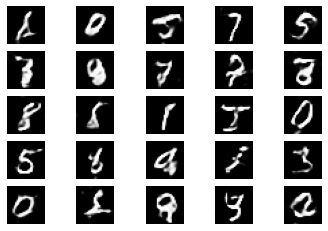

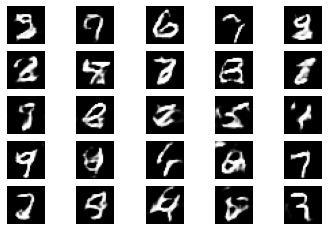

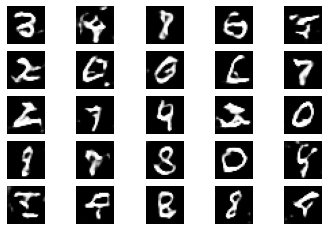

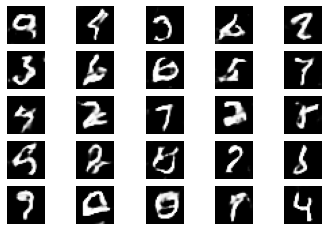

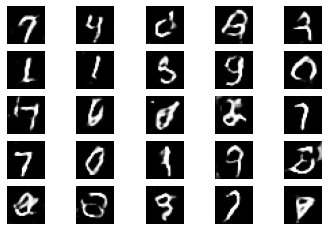

In [19]:
gan_train(4001, 32, 200)

In [3]:
from tensorflow.keras.layers import MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))


In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)       

In [5]:
model = Sequential()
model.add(Dense(30,  input_dim=12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [6]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 30)                390       
_________________________________________________________________
dense_3 (Dense)              (None, 12)                372       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 875
Trainable params: 875
Non-trainable params: 0
_________________________________________________________________
